<!-- https://www.kaggle.com/code/iakhtar0/63-next-word-predictor-lstm-campusx -->

In [1]:
%matplotlib inline

In [2]:
import sys
import platform
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import nltk
import sklearn

print("🔧 Environment Information")
print("=" * 40)
print(f"Python version      : {platform.python_version()}")
print(f"TensorFlow version  : {tf.__version__}")
print(f"NumPy version       : {np.__version__}")
print(f"Pandas version      : {pd.__version__}")
print(f"Matplotlib version  : {matplotlib.__version__}")
print(f"Seaborn version     : {sns.__version__}")
print(f"NLTK version        : {nltk.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")
print("=" * 40)

# Optional: GPU info
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0].name}")
else:
    print("⚠️ No GPU detected (running on CPU).")
tf.keras.backend.clear_session()
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)



2025-11-20 10:30:16.155254: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


🔧 Environment Information
Python version      : 3.12.3
TensorFlow version  : 2.20.0
NumPy version       : 2.3.4
Pandas version      : 2.3.3
Matplotlib version  : 3.10.7
Seaborn version     : 0.13.2
NLTK version        : 3.9.2
scikit-learn version: 1.7.2
✅ GPU detected: /physical_device:GPU:0


In [3]:
from pathlib import Path
NOTEBOOK_DIR  = Path().resolve()
BASE_DIR = NOTEBOOK_DIR.parents[1]
DATASET_DIR = BASE_DIR /  "data" / 'Twitter' / "preprocessed"
DATASET_FILE_PATH = DATASET_DIR  / 'train.csv'
DATASET_FILE_PATH.exists()

True

In [4]:
df = pd.read_csv(DATASET_FILE_PATH,usecols=["sentiment","cleaned_text"],nrows=1000)
df["cleaned_text"] = df["cleaned_text"].astype(str)
print("Null values",df.isnull().sum())
print("Shape of df :",df.shape)

Null values sentiment       0
cleaned_text    0
dtype: int64
Shape of df : (1000, 2)


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

- https://www.geeksforgeeks.org/nlp/tf-idf-representations-in-tensorflow/

In [7]:
# Create a CountVectorizer Object
vectorizer = tf.keras.layers.TextVectorization(
    output_mode="tf_idf",
    # output_mode="int",
    ngrams=None,
)
corpus  = df["cleaned_text"]
vectorizer.adapt(corpus)
tfidf_matrix = vectorizer(corpus)

I0000 00:00:1763634625.415133   61976 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6


In [8]:
vocab_size = len(vectorizer.get_vocabulary())
vocab_size

1848

In [9]:
import rich
rich.print(tfidf_matrix)
print("Shape of matric",tfidf_matrix.shape)

tf.Tensor(
[[0.        2.310249  1.1182421 ... 0.        0.        0.       ]
 [0.        2.310249  0.        ... 0.        0.        0.       ]
 [0.        2.310249  0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        5.591211  ... 0.        0.        0.       ]
 [0.        1.1551245 3.3547263 ... 0.        0.        0.       ]
 [0.        0.        2.2364843 ... 0.        0.        0.       ]], shape=(935, 1848), dtype=float32)

Shape of matric (935, 1848)


- https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup
- https://www.tensorflow.org/api_docs/python/tf/one_hot

In [10]:
# your labels (strings)
labels = df['sentiment']
# 1. Create lookup layer
lookup = tf.keras.layers.StringLookup(output_mode="int", num_oov_indices=0)
lookup.adapt(labels)

# 2. Convert labels to integer IDs
y_int = lookup(labels)

# 3. Convert to one-hot
num_classes = lookup.vocabulary_size()
y_onehot = tf.one_hot(y_int, depth=num_classes)

print("First 5 Int labels:", y_int[:5])
print("First 5  One-hot:", y_onehot[:5])
print("Vocabulary:", lookup.get_vocabulary())
print("Shape of y+onehot",y_onehot.shape)

First 5 Int labels: tf.Tensor([0 0 0 0 0], shape=(5,), dtype=int64)
First 5  One-hot: tf.Tensor(
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]], shape=(5, 4), dtype=float32)
Vocabulary: [np.str_('Positive'), np.str_('Neutral'), np.str_('Negative'), np.str_('Irrelevant')]
Shape of y+onehot (935, 4)


In [11]:
from keras.models import Sequential
from keras.layers import SimpleRNN , Dense , Embedding 
import mlflow
import mlflow.tensorflow
import warnings
warnings.filterwarnings("ignore")
print("Project base dir is :",BASE_DIR)

Project base dir is : /home/srirama/sr_proj/EmotionAnalysis


In [12]:
# tracking_path = f"file:///{BASE_DIR.as_posix()}/mlruns"
tracking_path = f"http://localhost:5000/"

mlflow.set_tracking_uri(tracking_path)
print("Tracking URI:", mlflow.get_tracking_uri())


Tracking URI: http://localhost:5000/


In [13]:
mlflow.set_experiment("1-RNN")

<Experiment: artifact_location='mlflow-artifacts:/2', creation_time=1763625562449, experiment_id='2', last_update_time=1763625562449, lifecycle_stage='active', name='1-RNN', tags={}>

In [14]:
tfidf_matrix.shape , y_onehot.shape

(TensorShape([935, 1848]), TensorShape([935, 4]))

In [15]:
import tensorflow as tf
# number of samples
n = tfidf_matrix.shape[0]
idx = tf.random.shuffle(tf.range(n))
X = tf.gather(tfidf_matrix, idx)
y = tf.gather(y_onehot, idx)

split = int(0.6 * n)

X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]


In [16]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val))

BATCH_SIZE = 32

train_ds = (
    train_ds
    .shuffle(buffer_size=len(X_train))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    val_ds
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


In [17]:
# Define constants
timestep = X.shape[1]
vocab_size = X.shape[1] #
embed_dim = 16                 # small, efficient
rnn_units = 32  
num_classes = y.shape[1]
run = mlflow.start_run(run_name="TreasureHunt-1")
mlflow.log_param("preprocess", "Embedding")
mlflow.log_param("vocab_size", vocab_size)
mlflow.log_param("embed_dim", embed_dim)
mlflow.log_param("timesteps", timestep)
mlflow.log_param("rnn_units", rnn_units)
mlflow.tensorflow.autolog()

In [18]:
# ---- Model ----
model = Sequential()
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embed_dim,
    input_length=timestep
))
model.add(SimpleRNN(rnn_units, return_sequences=False))
model.add(Dense(32, activation="tanh"))
model.add(Dense(16, activation="tanh"))
model.add(Dense(8, activation="tanh"))
model.add(Dense(num_classes, activation="softmax"))
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [19]:
! ipynb-py-convert 3-TFIDF.ipynb 3-TFIDF.py

In [23]:
history = model.fit(train_ds, validation_data=val_ds, epochs=40)

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 512ms/step - accuracy: 0.4135 - loss: 0.5263 - val_accuracy: 0.4225 - val_loss: 0.5285
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 490ms/step - accuracy: 0.4135 - loss: 0.5262 - val_accuracy: 0.4225 - val_loss: 0.5283
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 566ms/step - accuracy: 0.4135 - loss: 0.5260 - val_accuracy: 0.4225 - val_loss: 0.5283
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 580ms/step - accuracy: 0.4135 - loss: 0.5259 - val_accuracy: 0.4225 - val_loss: 0.5284
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 577ms/step - accuracy: 0.4135 - loss: 0.5266 - val_accuracy: 0.4225 - val_loss: 0.5284
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 563ms/step - accuracy: 0.4135 - loss: 0.5265 - val_accuracy: 0.4225 - val_loss: 0.5286
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 548ms/step - accuracy: 0.4135 - loss: 0.5261 - val_accuracy: 0.4225 - val_loss: 0.5284
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 530ms/step - accuracy: 0.4135 - loss: 0.5259 - val_accura

2025/11/20 10:47:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'epochs', 'old_value': '5', 'new_value': '40'}]' for run ID='a2802fe3d6274a34820082cf8beaacff'.


KeyboardInterrupt: 

In [24]:
loss, accuracy = model.evaluate(val_ds)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.4225 - loss: 0.5283
Test Loss: 0.5283089876174927
Test Accuracy: 0.4224599003791809


In [21]:
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature
import numpy as np
input_schema = Schema([
    TensorSpec(np.dtype(np.float32), (-1, timestep, input_nodes), "input")
])
output_schema = Schema([
    TensorSpec(np.dtype(np.float32), (-1, num_classes), "output")
])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

In [22]:
# ---- Log Model ----
mlflow.tensorflow.log_model(model, "model",signature=signature)
# --- Log metrics ---
val_acc = history.history["val_accuracy"][-1]
val_loss = history.history["val_loss"][-1]
mlflow.log_metric("val_accuracy", val_acc)
mlflow.log_metric("val_loss", val_loss)

INFO:tensorflow:Assets written to: C:\Users\SriRam.A\AppData\Local\Temp\tmpsqeeoi45\model\data\model\assets


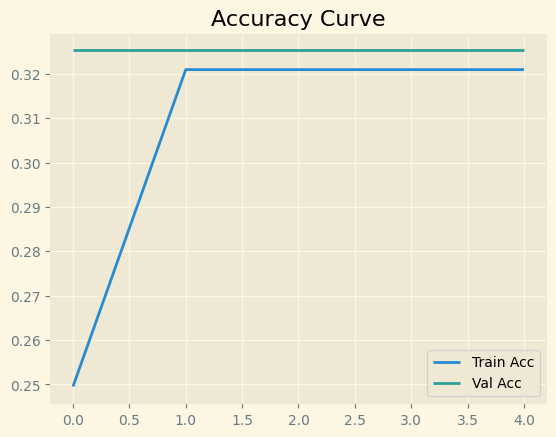

In [23]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")
mlflow.log_figure(plt.gcf(), "accuracy_curve.png")
plt.show()

116/116 [==============================] - 87s 750ms/step


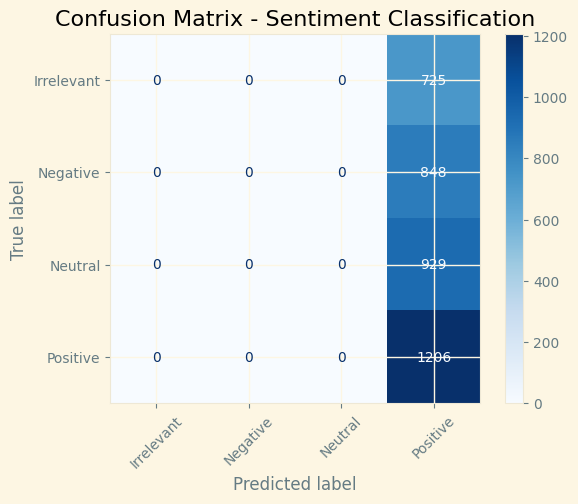


Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.00      0.00      0.00       725
    Negative       0.00      0.00      0.00       848
     Neutral       0.00      0.00      0.00       929
    Positive       0.33      1.00      0.49      1206

    accuracy                           0.33      3708
   macro avg       0.08      0.25      0.12      3708
weighted avg       0.11      0.33      0.16      3708



<Figure size 640x480 with 0 Axes>

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 1️⃣ Make predictions on the validation (test) data
y_pred = model.predict(X_val)

# 2️⃣ Convert probabilities → class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# 3️⃣ Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# 4️⃣ Display it visually
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Sentiment Classification")
plt.show()
mlflow.log_figure(plt.gcf(), "confusion_matrix.png")
# 5️⃣ Optional: detailed classification metrics
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))


In [25]:
mlflow.end_run()

In [26]:
! mlflow ui

^C
